# Perception des systèmes autonomes - IA716
# Projet 1 : CycleGAN et adaptation de domaine
## By: Davide GARCIA CIVIERO

L'objectif principal de ce projet est de faire de l'adaptation de domaine. Il s'agit de développer un modèle Cycle GAN permettant de générer des images SVHN à partir des images MNIST. <br>
Ensuite, il s'agit de créer un CNN qui sera entraîné sur les images SVHN générées par le Cycle GAN avec les labes des MNIST en entrée. Enfin, le modèle sera testé sur le dataset SVHN d'origine.

## Importation des librairies

In [ ]:
from tqdm import tqdm
from torchvision.utils import save_image
import os
import imageio
import torch
import torch.nn as nn
import imageio
import matplotlib.pyplot as plt
import torch.nn.functional as F

import sys
from torch.utils.data import DataLoader
import torch.optim as optim
from tqdm import tqdm

from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np

## Data Loader

Fonction permettant de récupérer les data loader des jeux de données MNIST et SVHN. Les images MNIST ayant une taille initiale de 28x28, toutes les images seront re-dimensionnées en 32x32 pour éviter tout problème de dimension. Les données seront également normalisées avec les paramètres 0.5 pour la moyenne et l'écart-type. Cela permet d'obtenir des valeurs comprises entre -1 et 1 pour chaque pixel.

In [ ]:
def get_loader(batch_size, exec="train"):
    transform_svhn = transforms.Compose([transforms.ToTensor()])
    transform_mnist = transforms.Compose([
                    transforms.Resize(32),
                    transforms.ToTensor(),
                    transforms.Normalize([0.5], [0.5])])
    if exec == "train":
      train = True
    else:
      train = False
    
    # Loading SVHN and MNIST datasets
    svhn = datasets.SVHN(root='./svhn', download=True, transform=transform_mnist, split=exec)
    mnist = datasets.MNIST(root='./mnist', download=True, transform=transform_mnist, train=train)
    
    # Concatenate SVHN and MNIST to get a single dataset
    svhn_loader = torch.utils.data.DataLoader(dataset=svhn, shuffle=True, 
                                              batch_size=batch_size, num_workers=2, pin_memory=True)
    mnist_loader = torch.utils.data.DataLoader(dataset=mnist, shuffle=True, 
                                               batch_size=batch_size, num_workers=2, pin_memory=True)
    
    return svhn_loader, mnist_loader

## Générateur MNIST vers SVHN

Ici, le générateur permettant d'obtenir les SVHN à partir des MNIST. Pour établir l'architecture, je me suis inspiré de l'architecture donnée par le papier de recherche présentant le Cycle GAN et d'un repository Github donnant déjà une implémentation. <br>
On a 6 blocs différents : les 5 premiers sont des convolutions, suivies d'une couche de Batch normalization et une couche de  LeakyReLU, le dernier bloc est une couche de convolution transposée avec une couche d'activation tangente hyperbolique. <br>
En entrée nous avons des images MNIST donc 1 channel et on souhaite générer des SVHN avec 3 channels : <br>
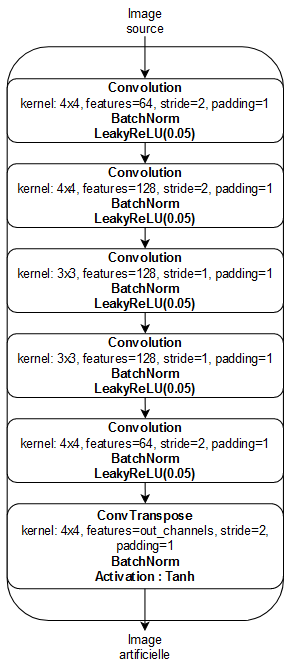

In [ ]:
# Generator from MNIST to SVHN
class GeneratorMS(nn.Module):
    def __init__(self, in_channels=1, out_channels=3, features=64):
        super(GeneratorMS, self).__init__()
        
        # Encoder layers
        self.fc1 = nn.Sequential(
            nn.Conv2d(in_channels, features, kernel_size=4, stride=2, padding=1, bias=True),
            nn.BatchNorm2d(features),
            nn.LeakyReLU(0.05)
        )
        self.fc2 = nn.Sequential(
            nn.Conv2d(features, features * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(features * 2),
            nn.LeakyReLU(0.05)
        )
        
        # Residual layers
        self.fc3 = nn.Sequential(
            nn.Conv2d(features * 2, features * 2, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(features * 2),
            nn.LeakyReLU(0.05)
        )
        self.fc4 = nn.Sequential(
            nn.Conv2d(features * 2, features * 2, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(features * 2),
            nn.LeakyReLU(0.05)
        )
        
        # Decoder layers
        self.fc5 = nn.Sequential(
            nn.ConvTranspose2d(features * 2, features, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(features),
            nn.LeakyReLU(0.05)
        )
        self.fc6 = nn.Sequential(
            nn.ConvTranspose2d(features, out_channels, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
        )
    
    def forward(self, x):
        fake = self.fc1(x)
        fake = self.fc2(fake)
        fake = self.fc3(fake)
        fake = self.fc4(fake)
        fake = self.fc5(fake)
        fake = self.fc6(fake)
        
        return fake

## Générateur SVHN vers MNIST

Ici, je développe le générateur qui prend en entrée les SVHN et génère des MNIST. L'achitecture est la même que pour le précédent générateur, ce qui change ce sont les entrées et les sorties : on prend en entrée des images SVHN donc qui possèdent 3 channels et on souhaite générer des MNIST, donc 1 channel en output.

In [ ]:
# Generator from SVHN to MNIST
class GeneratorSM(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features=64):
        super(GeneratorSM, self).__init__()
        
        # Encoder layers
        self.fc1 = nn.Sequential(
            nn.Conv2d(in_channels, features, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(features),
            nn.LeakyReLU(0.05)
        )
        self.fc2 = nn.Sequential(
            nn.Conv2d(features, features * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(features * 2),
            nn.LeakyReLU(0.05)
        )
        
        # Residual layers
        self.fc3 = nn.Sequential(
            nn.Conv2d(features * 2, features * 2, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(features * 2),
            nn.LeakyReLU(0.05)
        )
        self.fc4 = nn.Sequential(
            nn.Conv2d(features * 2, features * 2, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(features * 2),
            nn.LeakyReLU(0.05)
        )
        
        # Decoder layers
        self.fc5 = nn.Sequential(
            nn.ConvTranspose2d(features * 2, features, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(features),
            nn.LeakyReLU(0.05)
        )
        self.fc6 = nn.Sequential(
            nn.ConvTranspose2d(features, out_channels, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
        ) 
    
    def forward(self, x):
        fake = self.fc1(x)
        fake = self.fc2(fake)
        fake = self.fc3(fake)
        fake = self.fc4(fake)
        fake = self.fc5(fake)
        fake = self.fc6(fake)

        return fake
        

## Discriminateur MNIST

Ici je développe le discriminateur de MNIST, permettant d'améliorer le générateur SVHN -> MNIST. Le réseau va prendre en entrée les images MNIST et va devoir décider si l'image réseau est artificielle ou réelle. <br>
Nous avons 3 blocs avec des couches de convolution, de batch normalization et de LeakyReLU, et une couche de convoluiton finale. <br>
L'entrée est le nombre de channels des images acceptées, donc 1 pour les MNIST : <br>

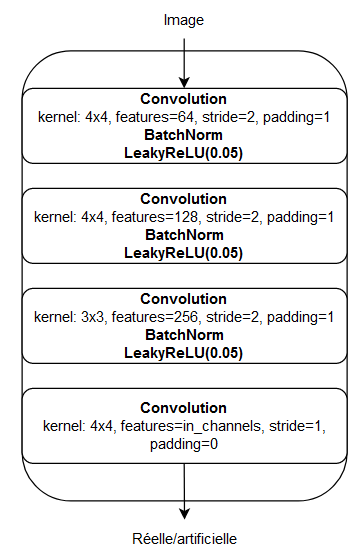

In [ ]:
# Discriminator for MNIST
class DiscriminatorM(nn.Module):
    def __init__(self, in_channels, features=64):
        super(DiscriminatorM, self).__init__()
        self.fc1 = nn.Sequential(
            nn.Conv2d(in_channels, features, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(features),
            nn.LeakyReLU(0.05)
        )
        self.fc2 = nn.Sequential(
            nn.Conv2d(features, features * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(features * 2),
            nn.LeakyReLU(0.05)
        )
        self.fc3 = nn.Sequential(
            nn.Conv2d(features * 2, features * 4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(features * 4),
            nn.LeakyReLU(0.05)
        )
        self.fc4 = nn.Sequential(
            nn.Conv2d(features * 4, in_channels, kernel_size=4, stride=1, padding=0, bias=False)
        )
        
    def forward(self, x):
        disc = self.fc1(x)
        disc = self.fc2(disc)
        disc = self.fc3(disc)
        disc = self.fc4(disc).squeeze()

        return disc

## Discriminateur SVHN

Enfin, ici je développe le discriminateur SVHN permettant d'améliorer le générateur MNIST -> SVHN. C'est le même fonctionnement mais pour les images SVHN, le but sera de réussir à tromper le discriminateur en générant des SVHN se rapprochant fortement des SVHN originaux. <br>
C'est la même architecture que le discriminateur précédent excepté pour l'entrée : le réseau prend 3 channels car on prend en entrée les SVHN originaux et générés.

In [ ]:
# Discriminator for SVHN
class DiscriminatorS(nn.Module):
    def __init__(self, in_channels, features=64):
        super(DiscriminatorS, self).__init__()
        self.fc1 = nn.Sequential(
            nn.Conv2d(in_channels, features, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(features),
            nn.LeakyReLU(0.05)
        )
        self.fc2 = nn.Sequential(
            nn.Conv2d(features, features * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(features * 2),
            nn.LeakyReLU(0.05)
        )
        self.fc3 = nn.Sequential(
            nn.Conv2d(features * 2, features * 4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(features * 4),
            nn.LeakyReLU(0.05)
        )
        self.fc4 = nn.Sequential(
            nn.Conv2d(features * 4, in_channels, kernel_size=4, stride=1, padding=0, bias=False)
        )
        
    def forward(self, x):
        disc = self.fc1(x)
        disc = self.fc2(disc)
        disc = self.fc3(disc)
        disc = self.fc4(disc).squeeze()

        return disc

Pour la suite du notebook, notamment la génération des SVHN servant à l'entraînement du classifieur CNN, les paramètres des quatre modèles seront chargés pour éviter de relancer à chaque fois l'entraînement qui reste relativement long. Les modèles fournis sont ceux que j'ai obtenus après de nombreux essais et ce sont ceux qui donnent des meilleurs résultats selon moi.

## Entraînement du Cycle GAN

La fonction "train_fn" permet d'entraîner le CycleGAN en prenant en paramètres:
- Le nombre d'epochs
- La taille du batch
- Les discriminateurs MNIST et SVHN
- Les générateurs MNIST et SVHN
- Les data loders des jeux de données MNIST et SVHN
- Les optimiseurs pour les discriminateurs et les générateurs
- Les fonctions de coût (L1 loss et Mean Squared Error)
- Et les deux derniers paramètres étant les scaler des discriminateurs et des générateurs.

In [ ]:
# mnist to svhn
# MNIST to SVHN
def train_fn(epochs, batch_size, path, disc_MNIST, disc_SVHN, gen_SVHN, gen_MNIST, svhn_loader, mnist_loader, opt_disc, opt_gen, l1, mse, d_scaler, g_scaler):
    # create iterable objects for svhn and mnist
    # Loop over epochs
    loss = list()
    for step in tqdm(range(epochs)):
      
      # take next batch
      svhn_iter = iter(svhn_loader)
      mnist_iter = iter(mnist_loader)
      # Loop over actual batch
      for _ in range(batch_size):
        # Take next values
        svhn, a = svhn_iter.next()
        mnist, b = mnist_iter.next()

        # Send them to device GPU
        svhn = svhn.to(DEVICE)
        mnist = mnist.to(DEVICE)

        # Train discriminator MNIST and SVHN
        with torch.cuda.amp.autocast():
          fake_mnist = gen_MNIST(svhn)
          
          D_MNIST_real = disc_MNIST(mnist)
          D_MNIST_fake = disc_MNIST(fake_mnist.detach())
          D_MNIST_real_loss = mse(D_MNIST_real, torch.ones_like(D_MNIST_real))
          D_MNIST_fake_loss = mse(D_MNIST_fake, torch.zeros_like(D_MNIST_fake))
          D_MNIST_loss = D_MNIST_real_loss + D_MNIST_fake_loss
          
          fake_svhn = gen_SVHN(mnist)           
          
          D_SVHN_real = disc_SVHN(svhn)
          D_SVHN_fake = disc_SVHN(fake_svhn.detach())
          D_SVHN_real_loss = mse(D_SVHN_real, torch.ones_like(D_SVHN_real))
          D_SVHN_fake_loss = mse(D_SVHN_fake, torch.zeros_like(D_SVHN_fake))
          D_SVHN_loss = D_SVHN_real_loss + D_SVHN_fake_loss
          
          # put it together
          D_loss = (D_MNIST_loss + D_SVHN_loss) / 2

        opt_disc.zero_grad()
        d_scaler.scale(D_loss).backward()
        d_scaler.step(opt_disc)
        d_scaler.update()

        # Train generator MNIST and SVHN
        with torch.cuda.amp.autocast():
          D_MNIST_fake = disc_MNIST(fake_mnist)
          D_SVHN_fake = disc_SVHN(fake_svhn)
          loss_G_MNIST = mse(D_MNIST_fake, torch.ones_like(D_MNIST_fake))
          loss_G_SVHN = mse(D_SVHN_fake, torch.ones_like(D_SVHN_fake))
          
          # cycle loss
          cycle_svhn = gen_SVHN(fake_mnist)
          cycle_mnist = gen_MNIST(fake_svhn)
          
          cycle_svhn_loss = l1(svhn, cycle_svhn)
          cycle_mnist_loss = l1(mnist, cycle_mnist)
          
          # identity loss
          identity_svhn = gen_SVHN(mnist)
          identity_mnist = gen_MNIST(svhn)
          identity_svhn_loss = l1(svhn, identity_svhn)
          identity_mnist_loss = l1(mnist, identity_mnist)

          # add all together
          G_loss = (
              loss_G_SVHN
              + loss_G_MNIST
              + cycle_svhn_loss * LAMBDA_CYCLE
              + cycle_mnist_loss * LAMBDA_CYCLE
              + identity_mnist_loss * LAMBDA_IDENTITY
              + identity_svhn_loss * LAMBDA_IDENTITY
          )
          opt_gen.zero_grad()
          g_scaler.scale(G_loss).backward()
          g_scaler.step(opt_gen)
          g_scaler.update()

        loss.append(G_loss.cpu().detach().numpy())

      save_image(fake_mnist[:5]*0.5+0.5, path+f"/mnist_{step}.png")
      save_image(fake_svhn[:5]*0.5+0.5, path+f"/svhn_{step}.png")
    plt.figure(figsize=(15, 8))
    plt.plot(loss)
    plt.show()

Dans ce cas, je boucle sur le nombre d'epochs et sur la taille du batch. <br>
Je calcule la loss du discriminateur MNIST en sommant les loss des discriminateurs "réels" et "fake". Je fais de même pour le discriminateur SVHN. <br>
Ensuite je calcule la loss du CycleGAN pour MNIST et pour SVHN auquel j'ajoute les loss des générateurs SVHN et MNIST. <br>
Dans une version précédente j'avais intégré l'Identity Loss que j'ai retiré car elle n'impactait pas beaucoup le score final du CNN.


Les différentes loss sont donc :
- Les loss des générateurs étant des Mean Squared Errors
- Les loss des cycle GAN (MNIST et SVHN)
- Les identity loss (pour MNIST et SVHN) <br>

Les cycle et identity loss sont pondérées par des coefficients à définir à la main, ce qui constituent des hyper-paramètres. J'ai réalisé plusieurs tests afin de déterminer quel coefficients mettre. J'ai décidé de ne pas considérer l'identity loss car elles ne joue que sur le taux de couleur des générations ce qui ne change pas beaucoup de choses quant au score de classification avec le CNN (comme j'ai pu l'observer après plusieurs essais).

In [ ]:
# PARAMETERS DEFINITION

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
LEARNING_RATE = 2*1e-4
LAMBDA_IDENTITY = 0.0
LAMBDA_CYCLE = 10.0
NUM_WORKERS = 4
BATCH_SIZE = 64
NUM_EPOCHS = 351
PATH = "./test350_/"

Les hyper-paramètres ci-dessus sont ceux qui ont été utilisés pour générer les SVHN. J'ai pu réalisé plusieurs tests en faisant varier certains paramètres (notamment le learning rate, le nombre d'epochs et la taille du batch).

In [ ]:
os.makedirs(PATH)

FileExistsError: ignored

Ici, la fonction main. On y initialise les discriminateurs, générateurs ainsi que tous les paramètres cités plus haut pour lancer l'entraînement du Cycle GAN. Je sauvegarde également les paramètres des modèles pour les réutiliser pour l'étape d'inférence. <br>
J'ai choisi l'optimiseur Adam pour ses performances, mais surtout pour sa rapidité de convergence. <br>
J'ai également deux loss différentes :
- Mean Squared Error : utilisée pour calculer la loss des discriminateurs.
- L1 loss (Least Absolute Deviation) : utilisée pour calculer la loss entre le SVHN original et le SVHN généré. Cette loss est choisie car elle devrait forcer l'image générée à ressembler à l'image d'origine selon le papier de recherche sur Cycada [1] <br>



In [ ]:
def main():
    disc_MNIST = DiscriminatorM(in_channels=1).to(DEVICE) # Real or fake mnist
    disc_SVHN = DiscriminatorS(in_channels=3).to(DEVICE) # Real or fake svhn
    gen_SVHN = GeneratorMS(in_channels=1, out_channels=3).to(DEVICE) # Generate svhn
    gen_MNIST = GeneratorSM(in_channels=3, out_channels=1).to(DEVICE) # Generate mnist
    opt_disc = optim.Adam(
        list(disc_MNIST.parameters()) + list(disc_SVHN.parameters()),
        lr = LEARNING_RATE,
        betas=(0.5, 0.999),
    )
    opt_gen = optim.Adam(
        list(gen_SVHN.parameters()) + list(gen_MNIST.parameters()),
        lr=LEARNING_RATE,
        betas=(0.5, 0.999),
    )

    L1 = nn.L1Loss()
    mse = nn.MSELoss()

    
    loader_svhn, loader_mnist = get_loader(BATCH_SIZE)
    
    g_scaler = torch.cuda.amp.GradScaler()
    d_scaler = torch.cuda.amp.GradScaler()

    train_fn(NUM_EPOCHS, BATCH_SIZE, PATH, disc_MNIST, disc_SVHN, gen_SVHN, gen_MNIST, loader_svhn, loader_mnist, opt_disc, opt_gen, L1, mse, d_scaler, g_scaler)
    torch.save(disc_MNIST.state_dict(), '.discmnist.pt')
    torch.save(disc_SVHN.state_dict(), 'discsvhn.pt')
    torch.save(gen_SVHN.state_dict(), 'genMS.pt')
    torch.save(gen_MNIST.state_dict(), 'genSM.pt')
    
if "__name__" == "__main__":
    print("hue")
    main()

Dans les deux cellules suivantes, je lance la fonction main qui doit initialiser tout le modèle et lancer l'entraînement. Ici je les ai commentées car les générateurs et discriminateurs ont déjà été entraînés et je charge les paramètres juste après dans le notebook lors de l'étape pour générer les SVHN.

In [ ]:
#main()

## Chargement du modèle et phase de test (inférence)

Comme dit précédement, les modèles sont chargés et envoyé sur le GPU.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
gen_SVHN_test = GeneratorMS(in_channels=1, out_channels=3)#.to(DEVICE)
gen_SVHN_test.load_state_dict(torch.load('/content/genMS.pt'))
gen_SVHN_test.eval()

gen_MNIST_test = GeneratorSM(in_channels=3, out_channels=1)#.to(DEVICE)
gen_MNIST_test.load_state_dict(torch.load('/content/genSM.pt'))
gen_MNIST_test.eval()

GeneratorSM(
  (fc1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.05)
  )
  (fc2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.05)
  )
  (fc3): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.05)
  )
  (fc4): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.05)
  )
  (fc5): Sequent

J'utilise la fonction "get_loader" pour obtenir les data loader de MNIST et de SVHN. Je prend une taille de batch de 64 pour le train et le test.

In [ ]:
# Get test sample
svhn_loader_train, mnist_loader_train = get_loader(64, "train")
svhn_loader_test, mnist_loader_test = get_loader(64, "test")

Using downloaded and verified file: ./svhn/train_32x32.mat
Using downloaded and verified file: ./svhn/test_32x32.mat


In [ ]:
svhn_test, svhn_labels = iter(svhn_loader_test).next()
mnist_test, mnist_labels = iter(mnist_loader_test).next()
print(svhn_test.shape)

torch.Size([64, 3, 32, 32])


Fonction permettant de plotter les images

In [ ]:
def plot_tensorImg(tensorImg):
  plt.imshow(transforms.ToPILImage()(tensorImg), interpolation="bicubic")

Fonction permettant de plotter des images MNIST, leur SVHN généré correspondant et le MNIST re-généré à partir du SVHN artificiel.

In [ ]:
def plot_images(mnist_real, idx):
  plt.figure(figsize=(10, 8))
  plt.subplot(131)
  plot_tensorImg(mnist_real[idx])
  plt.title('MNIST input with label = {}'.format(mnist_labels[idx]))
  plt.subplot(132)
  svhn1 = gen_SVHN_test(mnist_test)
  plot_tensorImg(svhn1[idx])
  plt.title('SVHN generated')
  plt.subplot(133)
  mnist_regen = gen_MNIST_test(svhn1)
  plot_tensorImg(mnist_regen[idx])
  plt.title('MNIST re-generated')

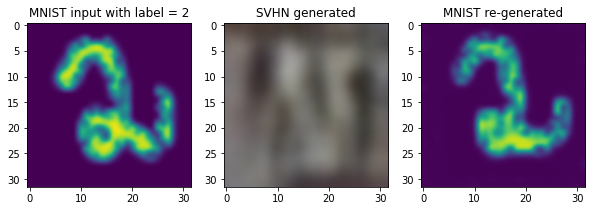

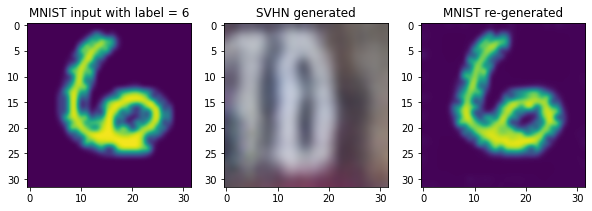

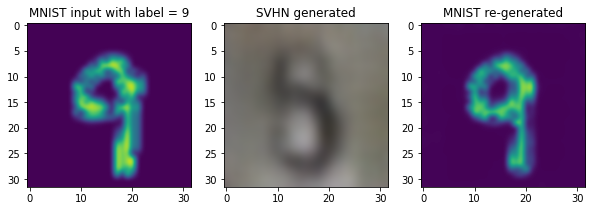

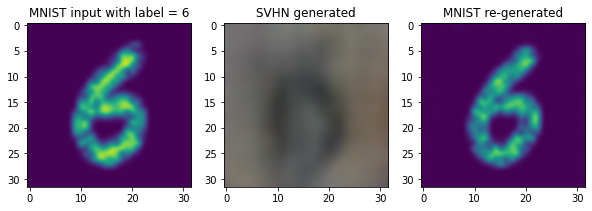

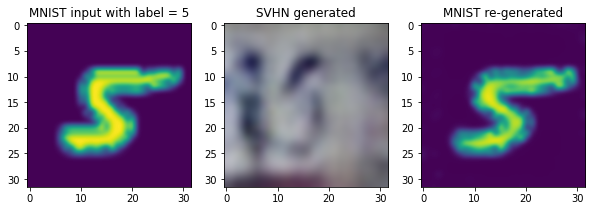

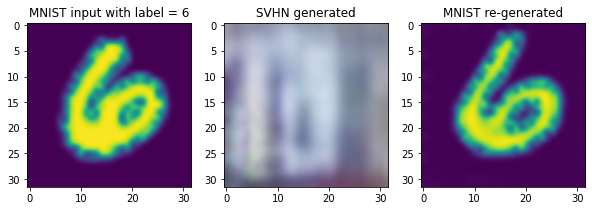

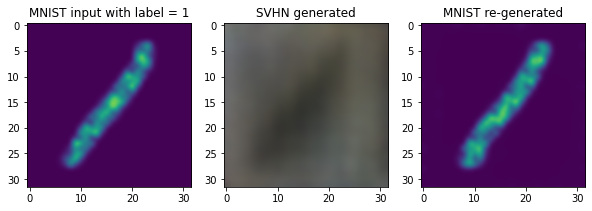

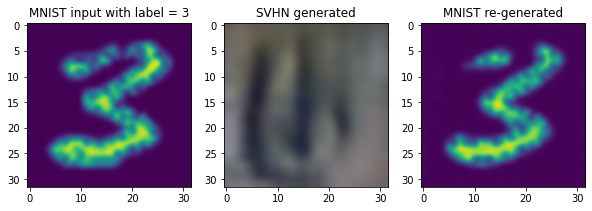

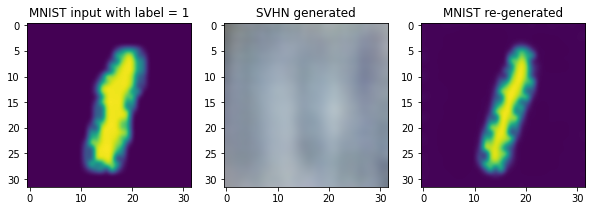

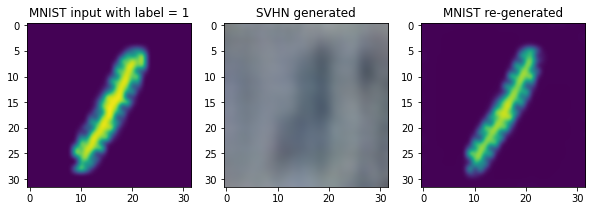

In [ ]:
for i in range(10):
  plot_images(mnist_test, i)

La majorité des SVHN générées à partir de MNIST sont d'assez mauvaise qualité, bien que certaines sont assez bien générées et on arrive à distinguer le chiffre. De plus, le label semble être assez bien conservé : quand on re-génère en MNIST on obtient bien le bon label du MNIST de départ (même si le générateur SVHN a tendance à se tromper).

## Classifieur CNN

Il s'agit de la deuxième étape du projet. Les données MNIST seront utilisées pour générer un nouveau dataset de SVHN "artificiels" et les labels MNIST seront ceux des SVHN générés. <br>
Le CNN sera donc entraîné avec ce nouveau dataset artificiel, mais l'inférence et le test du CNN se fera sur le test set du SVHN d'origine.

### Création du dataset SVHN généré

In [ ]:
# Model on GPU device
gen_SVHN_test.to(DEVICE)

GeneratorMS(
  (fc1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.05)
  )
  (fc2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.05)
  )
  (fc3): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.05)
  )
  (fc4): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.05)
  )
  (fc5): Sequential(
    (0)

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [ ]:
def to_numpyCPU(x):
    if torch.cuda.is_available():
        x = x.cpu()
    return x.data.numpy()

In [ ]:
gensvhn_data = list()
for n, (x, y) in enumerate(iter(mnist_loader_train)):
    gensvhn_data.append((to_numpyCPU(gen_SVHN_test(x.to(DEVICE))), y.numpy()))

### Architecture du CNN

J'ai choisi l'architecture de réseau de neurones convolutionnel suivante : <br>
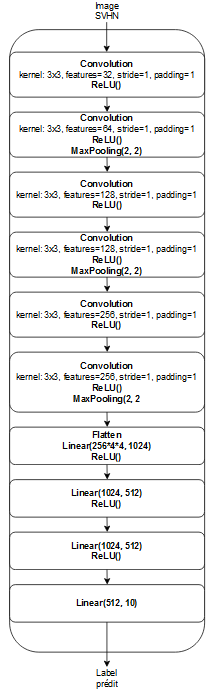

In [ ]:
class SVHNCnnModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4

            nn.Flatten(), 
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10))
        
    def forward(self, xb):
        # Flatten the image tensors
        #xb = xb.view(xb.size(0), -1)
        return self.network(xb)
    
    def training_step(self, batch):
      images, labels = batch

      images = torch.from_numpy(images) # cast to torch tensor
      labels = torch.from_numpy(labels)

      images = images.to(DEVICE)
      labels = labels.to(DEVICE)
      out = self(images)                  # Generate predictions

      loss = F.cross_entropy(out, labels) # Calculate loss
      return loss

    
    def validation_step(self, batch):
        images, labels = batch

        images = torch.from_numpy(images) # cast to torch tensor
        labels = torch.from_numpy(labels)

        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

Fonctions pour évaluer en entraîner le modèle.

In [ ]:
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in tqdm(range(epochs)):
        # Training Phase
        model.train()
        train_losses = []
        for batch in train_loader:
          loss = model.training_step(batch)
          train_losses.append(loss)
          loss.backward()
          optimizer.step()
          optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy en fonction des epochs');

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Evolution de la loss en fonction des epochs');

### Entraînement du modèle CNN

In [ ]:
# Model (on GPU)
model_cnn = SVHNCnnModel()
model_cnn.to(DEVICE)

SVHNCnnModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=4096, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_feature

In [ ]:
num_epochs = 40
opt_func = torch.optim.Adam
lr = 0.0003

Pour entraîner le modèle CNN, je choisi 780 batchs des SVHN générés et le reste est alloué au set de validation. Ainsi nous avons : 
- Environ 49920 données d'entraînement
- Environ 10080 données de validation <br>

Ce qui fait une répartition 84% d'entraînement et 16% de validation.

In [ ]:
history = fit(num_epochs, lr, model_cnn, gensvhn_data[:780], gensvhn_data[780:], opt_func)

  2%|▎         | 1/40 [00:14<09:35, 14.76s/it]

Epoch [0], val_loss: 0.2303, val_acc: 0.9266


  5%|▌         | 2/40 [00:29<09:24, 14.86s/it]

Epoch [1], val_loss: 0.1794, val_acc: 0.9434


  8%|▊         | 3/40 [00:44<09:07, 14.79s/it]

Epoch [2], val_loss: 0.1632, val_acc: 0.9483


 10%|█         | 4/40 [00:58<08:48, 14.69s/it]

Epoch [3], val_loss: 0.1962, val_acc: 0.9441


 12%|█▎        | 5/40 [01:13<08:31, 14.61s/it]

Epoch [4], val_loss: 0.1754, val_acc: 0.9533


 15%|█▌        | 6/40 [01:27<08:15, 14.58s/it]

Epoch [5], val_loss: 0.1478, val_acc: 0.9618


 18%|█▊        | 7/40 [01:42<08:01, 14.59s/it]

Epoch [6], val_loss: 0.1672, val_acc: 0.9574


 20%|██        | 8/40 [01:57<07:47, 14.61s/it]

Epoch [7], val_loss: 0.1357, val_acc: 0.9671


 22%|██▎       | 9/40 [02:11<07:33, 14.64s/it]

Epoch [8], val_loss: 0.1553, val_acc: 0.9625


 25%|██▌       | 10/40 [02:26<07:18, 14.61s/it]

Epoch [9], val_loss: 0.1461, val_acc: 0.9658


 28%|██▊       | 11/40 [02:40<07:02, 14.59s/it]

Epoch [10], val_loss: 0.1485, val_acc: 0.9669


 30%|███       | 12/40 [02:55<06:48, 14.57s/it]

Epoch [11], val_loss: 0.1528, val_acc: 0.9692


 32%|███▎      | 13/40 [03:10<06:33, 14.57s/it]

Epoch [12], val_loss: 0.1505, val_acc: 0.9693


 35%|███▌      | 14/40 [03:24<06:18, 14.57s/it]

Epoch [13], val_loss: 0.1932, val_acc: 0.9605


 38%|███▊      | 15/40 [03:39<06:03, 14.56s/it]

Epoch [14], val_loss: 0.1377, val_acc: 0.9688


 40%|████      | 16/40 [03:53<05:49, 14.55s/it]

Epoch [15], val_loss: 0.1624, val_acc: 0.9710


 42%|████▎     | 17/40 [04:08<05:34, 14.54s/it]

Epoch [16], val_loss: 0.1781, val_acc: 0.9643


 45%|████▌     | 18/40 [04:22<05:19, 14.53s/it]

Epoch [17], val_loss: 0.1600, val_acc: 0.9698


 48%|████▊     | 19/40 [04:37<05:04, 14.52s/it]

Epoch [18], val_loss: 0.1528, val_acc: 0.9735


 50%|█████     | 20/40 [04:51<04:50, 14.51s/it]

Epoch [19], val_loss: 0.1688, val_acc: 0.9654


 52%|█████▎    | 21/40 [05:06<04:35, 14.50s/it]

Epoch [20], val_loss: 0.1608, val_acc: 0.9687


 55%|█████▌    | 22/40 [05:20<04:20, 14.50s/it]

Epoch [21], val_loss: 0.1506, val_acc: 0.9715


 57%|█████▊    | 23/40 [05:35<04:06, 14.49s/it]

Epoch [22], val_loss: 0.2033, val_acc: 0.9652


 60%|██████    | 24/40 [05:49<03:51, 14.48s/it]

Epoch [23], val_loss: 0.1597, val_acc: 0.9721


 62%|██████▎   | 25/40 [06:04<03:37, 14.47s/it]

Epoch [24], val_loss: 0.1632, val_acc: 0.9720


 65%|██████▌   | 26/40 [06:18<03:22, 14.46s/it]

Epoch [25], val_loss: 0.1664, val_acc: 0.9731


 68%|██████▊   | 27/40 [06:32<03:07, 14.45s/it]

Epoch [26], val_loss: 0.1546, val_acc: 0.9735


 70%|███████   | 28/40 [06:47<02:53, 14.45s/it]

Epoch [27], val_loss: 0.1517, val_acc: 0.9692


 72%|███████▎  | 29/40 [07:01<02:38, 14.44s/it]

Epoch [28], val_loss: 0.1665, val_acc: 0.9746


 75%|███████▌  | 30/40 [07:16<02:24, 14.44s/it]

Epoch [29], val_loss: 0.1545, val_acc: 0.9739


 78%|███████▊  | 31/40 [07:30<02:09, 14.44s/it]

Epoch [30], val_loss: 0.1651, val_acc: 0.9750


 80%|████████  | 32/40 [07:45<01:55, 14.43s/it]

Epoch [31], val_loss: 0.1595, val_acc: 0.9737


 82%|████████▎ | 33/40 [07:59<01:40, 14.43s/it]

Epoch [32], val_loss: 0.1585, val_acc: 0.9749


 85%|████████▌ | 34/40 [08:13<01:26, 14.42s/it]

Epoch [33], val_loss: 0.1444, val_acc: 0.9745


 88%|████████▊ | 35/40 [08:28<01:12, 14.42s/it]

Epoch [34], val_loss: 0.2121, val_acc: 0.9695


 90%|█████████ | 36/40 [08:42<00:57, 14.41s/it]

Epoch [35], val_loss: 0.1707, val_acc: 0.9720


 92%|█████████▎| 37/40 [08:57<00:43, 14.41s/it]

Epoch [36], val_loss: 0.1565, val_acc: 0.9758


 95%|█████████▌| 38/40 [09:11<00:28, 14.40s/it]

Epoch [37], val_loss: 0.1723, val_acc: 0.9741


 98%|█████████▊| 39/40 [09:25<00:14, 14.40s/it]

Epoch [38], val_loss: 0.2201, val_acc: 0.9687


100%|██████████| 40/40 [09:40<00:00, 14.51s/it]

Epoch [39], val_loss: 0.1590, val_acc: 0.9738


#### Sauvegarde des poids du CNN

In [ ]:
torch.save(model_cnn.state_dict(), 'CNN.pt')

#### Affichage de la précision et des fonctions de perte

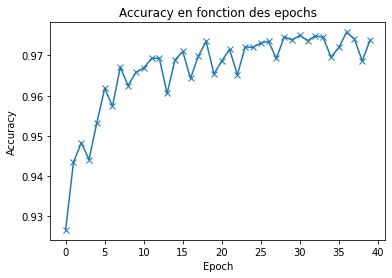

In [ ]:
plot_accuracies(history)

Le réseau de neurones convolutionnel semble être plutôt efficace avec une accuracy d'environ 97% au bout de 40 epochs, soit un temps de calcul de 9min18s.

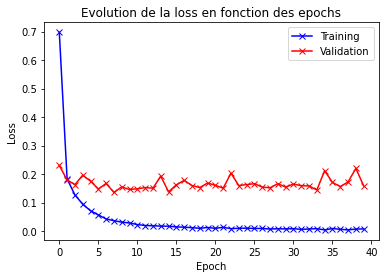

In [ ]:
plot_losses(history)

On observe que la loss de validation s'éloigne de la loss de training ce qui est un signe évident d'overfitting. Ce phénomène survient assez tôt (environ 4-5 epochs). Le modèle est en surapprentissage et risque de ne pas pouvoir généraliser.

### Prédictions

Passons maintenant aux prédictions sur les SVHN originaux avec le CNN entraîné sur les SVHN fictifs.

In [ ]:
transform = transforms.Compose([
                    transforms.ToTensor()])

train_ds = datasets.SVHN(root='./svhn', download=True, transform=transform, split="train")
test_ds = datasets.SVHN(root='./svhn', download=True, transform=transform, split="test")

Using downloaded and verified file: ./svhn/train_32x32.mat
Using downloaded and verified file: ./svhn/test_32x32.mat


In [ ]:
def predict_image(img, model):
    xb = img.unsqueeze(0)
    xb = xb.to(DEVICE)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)

    # Retrieve the class label

    return train_ds[preds[0].item()][1]

#### Chargement du modèle pré-entraîné

In [ ]:
model_cnn = SVHNCnnModel()
model_cnn.load_state_dict(torch.load('/content/CNN.pt'))
model_cnn.eval()
model_cnn.to(DEVICE)

SVHNCnnModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=4096, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_feature

Testons rapidement le modèle :

Label: 5 , Predicted: 3


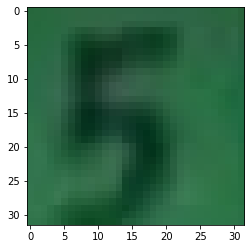

In [ ]:
img, label = test_ds[0]
plt.imshow(img.permute(1, 2, 0))
print('Label:', label, ', Predicted:', predict_image(img, model_cnn))

Ici le modèle n'arrive pas à prédir le bon label. Voyons les performances sur les sets d'entraînement et de test.

In [ ]:
def performances(test_ds):
  counter = 0
  for img, label in test_ds:
    if label == predict_image(img, model_cnn):
      counter += 1
  return counter / len(test_ds)

### Résultats du modèle CNN sur les SVHN originaux (test)

In [ ]:
acc_cnn_train = performances(train_ds)
acc_cnn_test = performances(test_ds)

In [ ]:
print("CNN accuracy on SVHN train set = {}%".format(round(acc_cnn_train, 5)*100))

CNN accuracy on SVHN train set = 18.435000000000002%


In [ ]:
print("CNN accuracy on SVHN test set = {}%".format(round(acc_cnn_test, 5)*100))

CNN accuracy on SVHN test set = 18.627%


# Commentaires sur les résultats et conclusion

Les résultats obtenus sont les suivants :
- 18.435% sur le train set de SVHN
- 18.627% sur le test set de SVHN <br>

Ces résultats sont très faibles, légèrement au dessus de l'aléatoire. J'ai réfléchis aux causes de cette faible précision et j'ai identifié deux sources :
- Le modèle de classification
- Les données en entrée <br>


  Il se peut qu'en choisissant un autre modèle plus performant, on puisse améliorer les performances globales de classification sur les SVHN originaux. Cependant, je ne pense pas que ça puisse donner des améliorations significatives. En effet, le classifieur donne déjà des résultats plutôt bons : 97% d'accuracy sur le set de validation. <br>
  La piste pouvant donner de meilleurs résultats est donc la deuxième : les données en entrée. <br>
  Premièrement, les données que j'ai généré ne sont pas très fidèles aux SVHN originaux, il y a quelques exemples d'images générées qui semblent bien correspondre aux MNIST en entrée tout en gardant le style SVHN, mais une grande majorité semble donner des résultats plutôt flous voir non reconnaissables. <br>
  Une piste d'amélioration serait donc d'améliorer le modèle CycleGAN pour qu'il puisse générer de meilleurs images, par exemple en introduisant le "semantic loss" présentée dans l'article sur "Cycada". Cela permettrait de générer des images en gardant la sémantique (donc en générant le bon chiffre). <br>
  Le dernier point à explorer, serait de faire de la Data Augmentation. En ajoutant des images transformées (rotations, changement de la luminosité, introduction de bruits etc.) il serait possible de mieux généraliser et de faire de meilleurs prédictions sur les SVHN. <br>
